In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from PIL import Image
from colorsys import hls_to_rgb
import scipy.io
import os
from scipy.special import comb
import matplotlib.colors as mcolors

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# System parameters

In [2]:
# size of the region of interest
roi_size_px = 332*3
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

# frequency cut-off of the lens (0.33 4xNA lens)
fc_lens = (np.arcsin(.33/4)/lambda_m)
# lens pupil filter in reciprocal space
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
FILTER = (Fx**2 + Fy**2) <= fc_lens**2


# Aberration parameter
Steps:
1. Decide region of interest
2. Crop ROI into patches
3. Specify each patch's aberration

In [3]:
# Load aberrations
mat = scipy.io.loadmat('./real_data/aberrations_full_FOV_angleCorrected_512.mat')
aberr_all = mat['FOV_ABERR']
del mat

mat = scipy.io.loadmat('./real_data/Fc_normalized.mat')
nFx_c = mat['nFx_c']
nFy_c = mat['nFy_c']
pupil_c = mat['pupil_c']

# Scale aberration to reasonable values rms ~ (2pi/14,2pi/2)
scale = 12
aberr_all = aberr_all*scale

Generate pupil function from Zernike coefficients

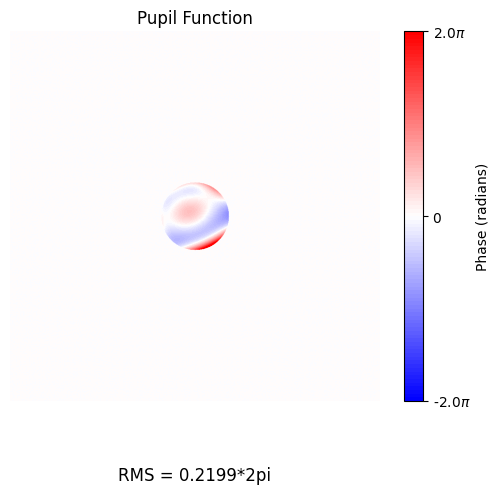

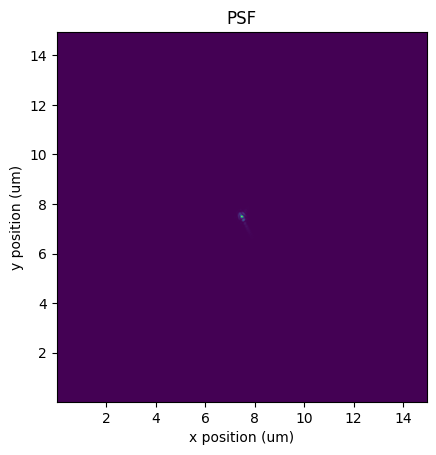

In [4]:
def zernikeBasis(deg, X, Y):
    m, n = X.shape

    # Create m's and n's from Noll indices
    npol = int(1/2 * (deg + 1) * (deg + 2))
    nn = np.zeros(npol)
    mm = np.zeros(npol)
    pp = np.zeros(npol)
    
    for ii in range(deg+1):
        idxs = np.arange(ii*(ii+1)//2, (ii*(ii+3))//2 + 1)
        nn[idxs] = ii
        mm[idxs] = np.arange(-ii, ii+1, 2)
        pp[idxs] = np.arange(ii, -1, -1)

    R = np.sqrt(X**2 + Y**2)
    T = np.arctan2(Y, X) * (180/np.pi)  # Convert to degrees

    B = np.zeros((m, n, npol))
    ZE = np.zeros((m*n, npol))
    SE = np.zeros((m*n, npol))

    for ii in range(npol):
        ni = nn[ii]
        mi = abs(mm[ii])
        pi = pp[ii]
        N = np.sqrt((2*(ni+1))/(1 + (mi == 0)))

        tmp = np.zeros((m, n))
        for k in range(0, int((ni-mi)//2)+1):
            tmp += (-1)**k * comb(ni-k, k) * comb(ni-2*k, ((ni-mi)//2)-k) * (R**(ni-2*k))

        if mm[ii] > 0:
            tmp = tmp * np.cos(np.deg2rad(mi*T))
        elif mm[ii] < 0:
            tmp = tmp * np.sin(np.deg2rad(mi*T))

        B[:, :, ii] = N * tmp
        ZE[:, ii] = (N * tmp).ravel()
        tmp2 = X**pi * Y**(ni-pi)
        SE[:, ii] = tmp2.ravel()

    Z = np.linalg.lstsq(SE, ZE, rcond=None)[0]
    return B, Z

def compute_pupil_function(z, deg, X, Y):
    B, _ = zernikeBasis(deg, X, Y)
    pupil = np.sum(B[:, :, :len(z)] * z[np.newaxis, np.newaxis, :], axis=2)
    return pupil

def get_pupil_phase(p, q, pupil):
    rows = np.any(FILTER, axis=1)
    cols = np.any(FILTER, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    x = np.linspace(-1, 1, cmax-cmin+1)
    y = np.linspace(-1, 1, rmax-rmin+1)
    X, Y = np.meshgrid(x, y)
    local_pupil = np.where(X**2 + Y**2 <= 1, 1, 0)
    z = np.array(aberr_all[p,q])
    abe_pupil = np.zeros_like(pupil).astype(np.float64)
    abe_pupil[rmin:rmax+1, cmin:cmax+1] = compute_pupil_function(z, len(z)-1, X, Y) * local_pupil
    return abe_pupil


def show_aberration(phase, pupil):
    # color map
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> W -> B
    cmap_name = 'custom_diverging'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

    # calculate rms in the pupil region
    masked_values = phase[pupil == 1]
    rms = np.sqrt(np.mean(masked_values**2))
    
    plt.imshow(phase, cmap=cm, vmin=-2.0*np.pi, vmax=2.0*np.pi)
    cbar = plt.colorbar(label='Phase (radians)')
    cbar.set_ticks([-2.0*np.pi, 0, 2.0*np.pi])
    cbar.set_ticklabels([r'-2.0$\pi$', '0', r'2.0$\pi$'])
    plt.title('Pupil Function')
    plt.annotate(f'RMS = {rms/(2*np.pi):.4f}*2pi', 
                 xy=(0.5, -0.2),  # Adjusted this value to make the label lower
                 xycoords='axes fraction', 
                 ha='center', va='center', 
                 fontsize=12)
        
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('off')
    plt.show()

abe_phase = get_pupil_phase(1,2,FILTER)
show_aberration(abe_phase, FILTER)

# Visualize PSF
abe_pupil = FILTER*np.exp(1j*abe_phase)
PSF = np.abs(np.fft.fftshift(np.fft.fft2(abe_pupil)))**2
plt.imshow(PSF, extent=[x_m[0]*1e6, x_m[-1]*1e6, y_m[0]*1e6, y_m[-1]*1e6])
plt.xlabel('x position (um)')
plt.ylabel('y position (um)')
plt.title('PSF')
plt.show()

zoom in central PSF

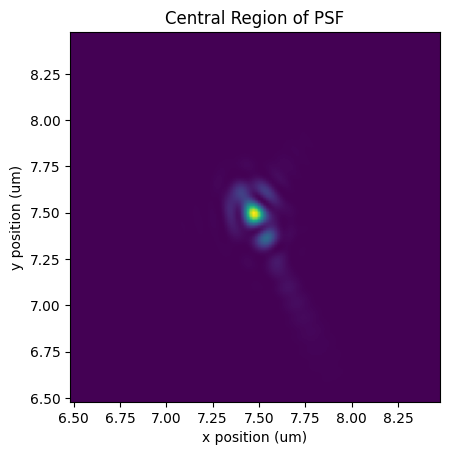

In [5]:
def plot_central_region(PSF, x_m, y_m, region_size=2e-6):
    # Extract the central region of the PSF
    x_center = (x_m[-1] + x_m[0]) / 2
    y_center = (y_m[-1] + y_m[0]) / 2
    x_indices = np.where((x_m >= x_center - region_size/2) & (x_m <= x_center + region_size/2))
    y_indices = np.where((y_m >= y_center - region_size/2) & (y_m <= y_center + region_size/2))
    central_PSF = PSF[y_indices[0][0]:y_indices[0][-1]+1, x_indices[0][0]:x_indices[0][-1]+1]

    # Plot the central region
    plt.imshow(central_PSF, extent=[x_m[x_indices[0][0]]*1e6, x_m[x_indices[0][-1]]*1e6, 
                                    y_m[y_indices[0][0]]*1e6, y_m[y_indices[0][-1]]*1e6])
    plt.xlabel('x position (um)')
    plt.ylabel('y position (um)')
    plt.title('Central Region of PSF')
    plt.show()


plot_central_region(PSF, x_m, y_m)

Create corresponding region crop functions (14\*14 patches, each 256\*256, 50% overlap)

In [6]:
# full image size
nx_f, ny_f = [2048, 2048]
# shift-invariant patch size
param_nx = 256
xroi = slice(905, 1161)
yroi = slice(678, 934)
imgSegSpc = 128

Xs = np.arange(-nx_f/2, nx_f/2, imgSegSpc) + xroi.start
Xs = Xs[(Xs > 0) & (Xs < nx_f - param_nx)]

Ys = np.arange(-ny_f/2, ny_f/2, imgSegSpc) + yroi.start
Ys = Ys[(Ys > 0) & (Ys < ny_f - param_nx)]

def cropFn(A, p, q):
    return A[int(Ys[p]):int(Ys[p])+param_nx, int(Xs[q]):int(Xs[q])+param_nx]


Define helper function that maps ROI coordinate back to full measurement coordinate

# Helper functions

In [7]:
# centered Fourier Transform
ft = lambda signal: np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(signal)))
ift = lambda signal: np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(signal)))

# circular shifting
def circshift2(input, x_shift_px, y_shift_px):
    return np.roll(np.roll(input, round(x_shift_px), axis=1), round(y_shift_px), axis=0)

def colorize(z):
    n,m = z.shape
    c = np.zeros((n,m,3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0 - 1.0/(1.0+abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a,b in zip(A,B)]
    return c

def imagecc(img_complex):
    '''
    imagecc(img_complex) displays an image where amplitude is mapped
    on the value and the phase is mapped on the hue.
    img_rgb =imagecc(img_complex) returns the corresponding RGB data,
    '''

    N_row, N_col = img_complex.shape

    map_func = lambda x, channel: np.minimum(6*np.mod(x-(channel+1)/3,1),1) * \
        np.maximum(np.minimum(6*(2/3-np.mod(x-(channel+1)/3,1)),1),0)

    img_abs = np.abs(img_complex.ravel())/(np.max(np.abs(img_complex.ravel())))
    img_arg = np.angle(img_complex.ravel())/(2*np.pi)+0.5

    img_rgb = np.zeros((N_row,N_col,3))

    img_rgb[:,:,0] = np.reshape(map_func(img_arg,1)*np.abs(img_abs),(N_row,N_col))
    img_rgb[:,:,1] = np.reshape(map_func(img_arg,2)*np.abs(img_abs),(N_row,N_col))
    img_rgb[:,:,2] = np.reshape(map_func(img_arg,3)*np.abs(img_abs),(N_row,N_col))

    return img_rgb


# Create object

## Create BPRP object
code modified from MIP, return obj_bprp

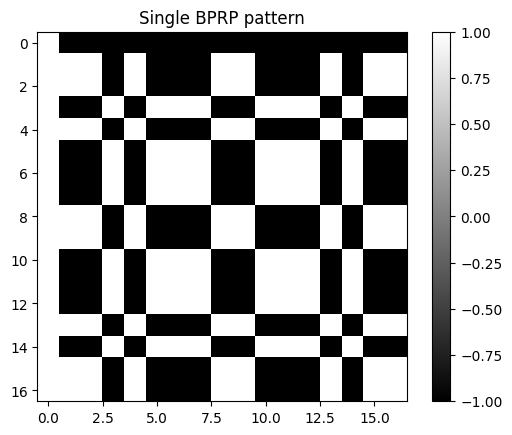

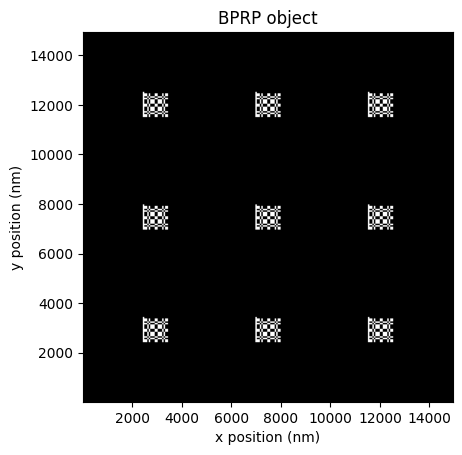

In [8]:
def bprp(Nx_prime, Ny_prime=None):
    """
    Generate a Binary Pseudo-Random Pattern (a.k.a modified Uniformly Redundant Array)
    
    Parameters:
    Nx_prime, Ny_prime: Integers
        Both should be prime numbers.
        
    Returns:
    ura: 2D numpy array
        2D-BPRP of size Nx_prime x Ny_prime
    
    References:
    Fenimore & Cannon "Coded aperture imaging with uniformly redundant arrays"
    dx.doi.org/10.1364/AO.17.000337
    dx.doi.org/10.1364/AO.28.004344
    dx.doi.org/10.1364/OE.22.019803
    """
    
    if Ny_prime is None:
        Ny_prime = Nx_prime

    if not (sympy.isprime(Nx_prime) and sympy.isprime(Ny_prime)):
        raise ValueError('Needs two prime numbers!')

    # basic array
    ba = np.zeros((Nx_prime, Ny_prime))

    # K is associated with Nx_prime and M is associated with Ny_prime.
    
    # a simple method to implement the equations is to evaluate mod(x^2,r) for
    # all x from 1 to r. The resulting values give the locations (I) in Cr
    # that contains +1. All other terms in Cr are -1.
    Cr = np.ones(Nx_prime) * -1
    cr_idx = sorted(set(np.mod(np.arange(1, Nx_prime + 1) ** 2, Nx_prime)))
    Cr[cr_idx] = 1

    Cs = np.ones(Ny_prime) * -1
    cs_idx = sorted(set(np.mod(np.arange(1, Ny_prime + 1) ** 2, Ny_prime)))
    Cs[cs_idx] = 1

    for ix in range(Nx_prime):
        for jy in range(Ny_prime):
            if ix == 0:
                ba[ix, jy] = 0
            elif ix != 0 and jy == 0:
                ba[ix, jy] = 1
            elif Cr[ix] * Cs[jy] == 1:
                ba[ix, jy] = 1
            else:
                ba[ix, jy] = 0

    # positive array
    pa = ba * 2 - 1
    # b[0, 0] has to be equal to 1 so that the sidelobes are flatter:
    pa[0, 0] = 1

    return pa

pattern = bprp(17, 17)
plt.imshow(pattern, cmap='gray')
plt.title('Single BPRP pattern')
plt.colorbar()
plt.show()


# BPRP size 17*60nm, corresponding to 17*4 pixels
magnified_pattern = np.kron(pattern+1, np.ones((4, 4)))

# 2.5um spacing between patterns
pattern_size = magnified_pattern.shape[0]
spacing = round(2.5e-6/dx_m) + pattern_size


obj_bprp = np.zeros((roi_size_px, roi_size_px))
width = 3*pattern_size + 2*spacing
shift = (roi_size_px - width) // 2
for i in range(3):
    for j in range(3):
        start_x = i * (pattern_size + spacing) + shift
        start_y = j * (pattern_size + spacing) + shift
        obj_bprp[start_x:start_x+pattern_size, start_y:start_y+pattern_size] = magnified_pattern


plt.imshow(obj_bprp, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('BPRP object')
plt.show()


## Create line object with roughness
return obj_lines

In [72]:
# initialize object
obj = np.ones((roi_size_px, roi_size_px))
roughness_nm = 0.2
obj_rough = obj * np.exp(1j * 2 * np.pi / lambda_m * 2 * roughness_nm * 1e-9 * np.random.randn(roi_size_px, roi_size_px))

# pitch size
p_nm = 4*dx_m*1e9
X_m, Y_m = np.meshgrid(x_m, y_m)
obj_lines = obj_rough * (1 + np.sign(np.sin(2 * np.pi * X_m / p_nm * 1e9)))


# Generate FPM measurements

## specify object

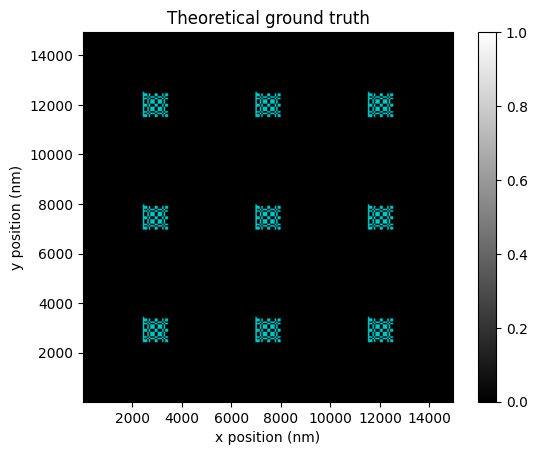

In [9]:
obj = obj_bprp
# normalize object
obj = obj / np.max(np.abs(obj))
img = np.abs(obj)**2

ideal_FILTER = (Fx**2 + Fy**2) <= ((1+np.sqrt(2))*fc_lens)**2
object_gt = ift(ft(obj)*ideal_FILTER)
img_gt = np.abs(object_gt)**2
img_lowres = np.abs(ift(ft(obj)*FILTER))**2

plt.imshow(imagecc(object_gt), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Theoretical ground truth')
plt.colorbar()
plt.show()


In [32]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
NA = .33/4

for sx in Sx:
    for sy in Sy:
        X0 = round(fc_lens*Dx_m*sx/np.sqrt(NA**2*(sx**2+sy**2-1)+1))
        Y0 = round(fc_lens*Dx_m*sy/np.sqrt(NA**2*(sx**2+sy**2-1)+1))
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)

## Aberration free simulation

In [10]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/bprp_noabe/'
if not os.path.exists(folder):
    os.makedirs(folder)
for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(FILTER*circshift2(ft(obj), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # Fix global exposure
        img_angle = img_angle / 2 * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'fineline_infocus_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

np.save(f'{folder}/gt.npy', obj)


## Aberratted simulation

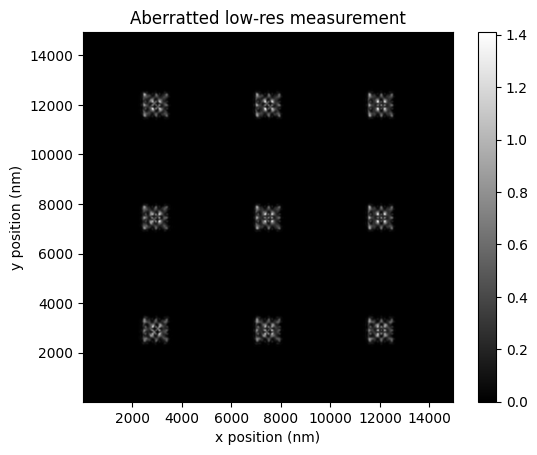

In [12]:
def forward(object, X0, Y0, FILTER=FILTER):
    obj_angle = np.zeros_like(object, dtype=np.complex128)
    for p in range(3):
        for q in range(3):
            abe = get_pupil_phase(p+5,q+5,FILTER)
            obj_patch = np.zeros_like(object)
            tile_size = 332
            obj_patch[p*tile_size:(p+1)*tile_size, q*tile_size:(q+1)*tile_size] = \
                object[p*tile_size:(p+1)*tile_size, q*tile_size:(q+1)*tile_size]
            abe_filter = FILTER*np.exp(1j*abe)
            obj_angle += ift(abe_filter * circshift2(ft(obj_patch), -X0, -Y0))
    img_angle = np.abs(obj_angle)**2
    return img_angle
                
img_angle = forward(obj, 0, 0)
plt.imshow(img_angle, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Aberratted low-res measurement')
plt.colorbar()
plt.show()


In [ ]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/bprp_abe/'
if not os.path.exists(folder):
    os.makedirs(folder)
for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        img_angle = forward(obj, X0, Y0)
        # scale by fixed exposure
        img_angle = img_angle / 2 * 255
        # print(np.max(img_angle))
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'aberrated_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')
        
np.save(f'{folder}/gt.npy', obj)
np.save(f'{folder}/center_abe.npy', get_pupil_phase(6,6,FILTER))

## (Optional) Include free-space propagation

In [18]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/defocus_5um/'
# free space propagation to the image plane
# defocus_m = 1e-6
# defocus_phase = np.exp(1j * 2 * np.pi * lambda_m * defocus_m * (Fx**2 + Fy**2))
# plt.imshow(np.angle(defocus_phase))
# plt.show()
obj_lines = np.load('./real_data/defocus_recon.npy')
obj_lines = obj_lines / np.max(obj_lines)

for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(FILTER*circshift2(ft(obj_lines), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # scale by fixed exposure
        img_angle = img_angle * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'defocus_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

# np.save('./sim_data/obj_fineline.npy', obj_lines)

# Simulate aberration
using ANSI Standard Zernikes

/var/folders/ck/jnrjwlt1209gwqhn1197cvpc0000gp/T/ipykernel_22579/1622836821.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coef = (-1)**s * np.math.factorial(n - s)
/var/folders/ck/jnrjwlt1209gwqhn1197cvpc0000gp/T/ipykernel_22579/1622836821.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coef /= np.math.factorial(s) * np.math.factorial((n + abs(m)) // 2 - s) * np.math.factorial((n - abs(m)) // 2 - s)


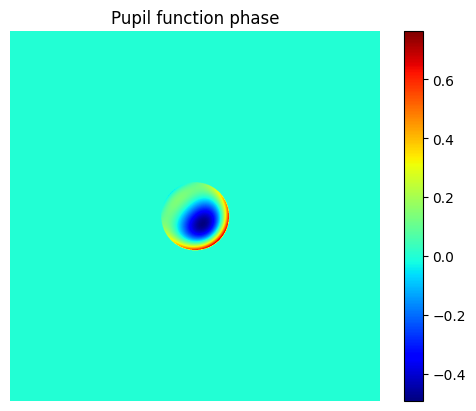

In [38]:
def zernike_polynomial(n, m, pupil):
    def polar_coords():
        """Generate polar coordinates for a given size"""
        x = np.linspace(-1, 1, cmax-cmin+1)
        y = np.linspace(-1, 1, rmax-rmin+1)
        X, Y = np.meshgrid(x, y)
        R = np.sqrt(X**2 + Y**2)
        T = np.arctan2(Y, X)
        T = np.where(T < 0, T + 2*np.pi, T)
        return R, T

    def radial_poly(n, m, R):
        """Calculate the radial polynomial"""
        radial = np.zeros_like(R)
        for s in range((n - abs(m)) // 2 + 1):
            coef = (-1)**s * np.math.factorial(n - s)
            coef /= np.math.factorial(s) * np.math.factorial((n + abs(m)) // 2 - s) * np.math.factorial((n - abs(m)) // 2 - s)
            radial += coef * R**(n - 2 * s)
        return radial

    rows = np.any(pupil, axis=1)
    cols = np.any(pupil, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    R, T = polar_coords()
    Radial = radial_poly(n, m, R)
    if m > 0:
        Z = np.sqrt(2*n+2) * Radial * np.cos(m * T)
    elif m < 0:
        Z = -np.sqrt(2*n+2) * Radial * np.sin(m * T)
    else:
        Z = np.sqrt(n+1) * Radial

    # Pad the Zernike polynomial to match the full pupil size
    padded_Z = np.zeros(pupil.shape)
    padded_Z[rmin:rmax+1, cmin:cmax+1] = Z
    return padded_Z

defocus_coef = 0.2
coma_coef = [0.1,0.1]
defocus = zernike_polynomial(2, 0, FILTER)
coma1 = zernike_polynomial(3, 1, FILTER)
coma2 = zernike_polynomial(3, -1, FILTER)
aberration = (defocus_coef*defocus+ coma_coef[0]*coma1 + coma_coef[1]*coma2)*FILTER
aberrated_FILTER = FILTER * np.exp(1j*aberration)

plt.imshow(np.angle(aberrated_FILTER), cmap='jet')
plt.title('Pupil function phase')
plt.axis('off')
plt.colorbar()
plt.show()


/var/folders/ck/jnrjwlt1209gwqhn1197cvpc0000gp/T/ipykernel_22579/1622836821.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coef = (-1)**s * np.math.factorial(n - s)
/var/folders/ck/jnrjwlt1209gwqhn1197cvpc0000gp/T/ipykernel_22579/1622836821.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coef /= np.math.factorial(s) * np.math.factorial((n + abs(m)) // 2 - s) * np.math.factorial((n - abs(m)) // 2 - s)


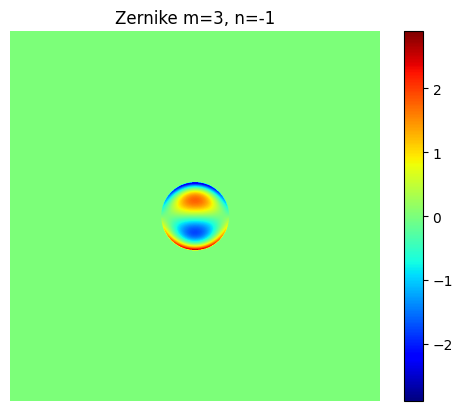

In [41]:
defocus_coef = 0
coma_coef = [0,1]
defocus = zernike_polynomial(2, 0, FILTER)
coma1 = zernike_polynomial(3, 1, FILTER)
coma2 = zernike_polynomial(3, -1, FILTER)
aberration = (defocus_coef*defocus+ coma_coef[0]*coma1 + coma_coef[1]*coma2)*FILTER

plt.imshow(aberration, cmap='jet')
plt.title('Zernike m=3, n=-1')
plt.axis('off')
plt.colorbar()
plt.show()

# Generate aberrated FPM measurements

In [42]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/'
for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(aberrated_FILTER*circshift2(ft(obj_lines), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # scale by fixed exposure
        img_angle = img_angle / 8 * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'./abe_invariant/aberrated_fineline_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

np.save('./sim_data/obj_fineline.npy', obj_lines)
np.save('./sim_data/pupil_function.npy', aberrated_FILTER)

# Spatial variant aberration

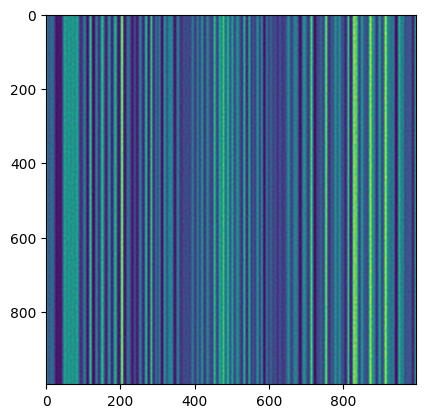

In [20]:
def forward(object, X0, Y0, FILTER=FILTER):
    obj_angle = np.zeros_like(object)
    for p in range(5,9):
        for q in range(5,9):
            abe = get_pupil(6,6, FILTER)*5
            obj_patch = np.zeros_like(object)
            obj_patch[p*256:(p+1)*256, q*256:(q+1)*256] = object[p*256:(p+1)*256, q*256:(q+1)*256]
            # pad abe to object size
            pad1 = (obj.shape[0]-abe.shape[0])//2
            pad2 = (obj.shape[0]-abe.shape[0]) - pad1
            abe_pad = np.pad(abe, ((pad1, pad2), (pad1, pad2)), 'constant', constant_values=0)
            abe_filter = FILTER*np.exp(1j*abe_pad)
            obj_angle += ift(abe_filter * circshift2(ft(object), -X0, -Y0))
    img_angle = np.abs(obj_angle)**2
    return img_angle
                
img_angle = forward(obj_lines, 0, 0)
plt.imshow(img_angle)
plt.show()


# Sx = np.linspace(-1,1,9)
# Sy = np.linspace(-1,1,9)
# folder = './sim_data/'
# for sx in Sx:
#     for sy in Sy:
#         X0 = round(sx*fc_lens*Dx_m)
#         Y0 = round(sy*fc_lens*Dx_m)
#         img_angle = forward(obj_lines, X0, Y0)
#         # scale by fixed exposure
#         img_angle = img_angle * 8 * 255
#         print(np.max(img_angle))
#         sx_str = str(sx).zfill(5)
#         sy_str = str(sy).zfill(5)
#         filename = f'aberrated_fineline_{sx_str}_data_{sy_str}.png'
#         img_pil = Image.fromarray(np.uint8(img_angle))
#         img_pil.save(f'{folder}/{filename}')



# Generate anime object

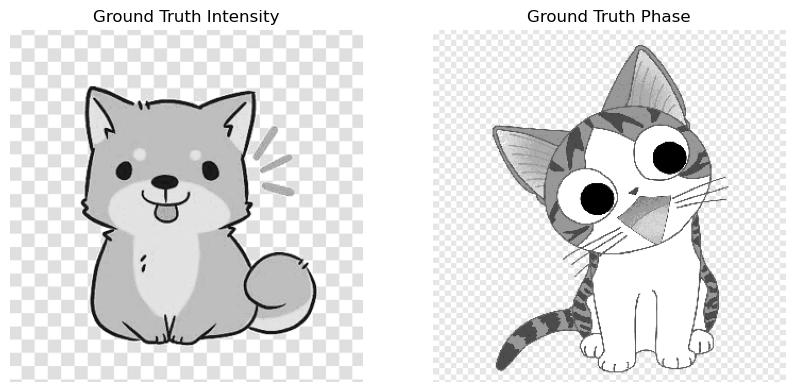

In [21]:
intensity = Image.open('intensity.png')
intensity = intensity.resize((roi_size_px, roi_size_px))
intensity = np.asarray(intensity.convert('L'))/255

phase = Image.open('phase.png')
phase = phase.resize((roi_size_px, roi_size_px))
phase = np.asarray(phase.convert('L'))/255*np.pi

obj_anime = intensity * np.exp(1j*phase)


# Create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Display the image
ax[0].imshow(np.abs(obj_anime), cmap='gray')
ax[1].imshow(np.angle(obj_anime), cmap='gray')

# Hide the axes
ax[0].axis('off')
ax[1].axis('off')

# Add titles
ax[0].set_title('Ground Truth Intensity')
ax[1].set_title('Ground Truth Phase')

# Show the plot
plt.show()


In [25]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_anime'
for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(aberrated_FILTER*circshift2(ft(obj_anime), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # scale by fixed exposure
        img_angle = img_angle / 3 * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'aberrated_line_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

np.save('obj_anime.npy', obj_anime)
np.save('pupil_function.npy', aberrated_FILTER)